### Dependencies

In [62]:
!pip install geopy pyvis scipy seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [63]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from geopy.distance import geodesic
from pyvis.network import Network

### Load Data

In [10]:
data_folder='/Users/antheaaaa_hax/Desktop/EducationalResourcesDistributionProject/source'

In [11]:
#converting txt file into Pandas dataframe format
def txt_to_df(filepath,delimiter=None):
    df=pd.read_csv(filepath,delimiter=delimiter)
    return df

filepath='/Users/antheaaaa_hax/Desktop/EducationalResourcesDistributionProject/source/course_enrolment_in_secondary_school.txt'
df=txt_to_df(filepath,'|')
df.head(10)

,Course Code,Course Description,Grade,Pathway or Destination,Enrolment
0,ADA1O,Drama,Grade 9,Open (Grade 9 - 12 level),30330
1,ADA2O,Drama,Grade 10,Open (Grade 9 - 12 level),18600
2,ADA3M,Drama,Grade 11,University/College Preparation (Grade 11 & 12 ...,8115
3,ADA3O,Drama,Grade 11,Open (Grade 9 - 12 level),1445
4,ADA4E,Drama,Grade 12,Workplace Preparation (Grade 11 & 12 level),125
5,ADA4M,Drama,Grade 12,University/College Preparation (Grade 11 & 12 ...,5410
6,ADB1O,Drama - Musical Theatre,Grade 9,Open (Grade 9 - 12 level),100
7,ADB2O,Drama - Musical Theatre,Grade 10,Open (Grade 9 - 12 level),240
8,ADB3M,Drama - Musical Theatre,Grade 11,University/College Preparation (Grade 11 & 12 ...,590
9,ADB3O,Drama - Musical Theatre,Grade 11,Open (Grade 9 - 12 level),20


In [ ]:
data_df={} #dictionary
df=None

for filename in os.listdir(data_folder):
    if not filename.endswith('.csv') and not filename.endswith('.xlsx') and not filename.endswith('.txt'):
        continue
    
    if filename.endswith('.csv'):
        csv_path=os.path.join(data_folder,filename)
        df=pd.read_csv(csv_path)
        data_df[filename]=df
        
    elif filename.endswith('.xlsx'):
        xlsx_path=os.path.join(data_folder,filename)
        df=pd.read_excel(xlsx_path,engine='openpyxl')
        data_df[filename]=df
        
    elif filename.endswith('.txt'):
        txt_path=os.path.join(data_folder,filename)
        df=pd.read_csv(txt_path,delimiter='|') 
        # df=txt_to_df(txt_path,'|')
        data_df[filename]=df  
         

In [13]:
for fname, df in data_df.items():
    print(f'{fname}: {df.shape}')

school_board_funding_2021.csv: (74, 17)
course_enrolment_in_secondary_school.txt: (1392, 5)
school_summary.csv: (4854, 6)
school-boards-capital-2024-en.xlsx: (77, 19)
school_information_and_student_demographics.xlsx: (4933, 49)
board_summary.csv: (2, 19)
school_board_contact_list_july2025_en_csv.csv: (85, 14)
School-Board-Funding-2021-22-EN.xlsx: (17, 2)
number_of_schools_by_board_2023-2024_en.csv: (76, 8)


In [78]:
# Data cleaning - school_information_and_student_demographics.xlsx
df = data_df["school_information_and_student_demographics.xlsx"]
df = df.dropna(subset=['Enrolment'])

school_cols = ["School Number", "School Name", "Board Name", "School Level", "Latitude", "Longitude"]
school_df = df[school_cols].copy()

board_cols = ["Board Number", "Board Name"]
lat_col = "Latitude"
lon_col = "Longitude"

# Group by board and calculate mean lat/lon
board_df = (
    df.groupby(board_cols, as_index=False)
    .agg({lat_col: "mean", lon_col: "mean"})
)
#fix the code here
# board_df[lat_col] = board_df[lat_col].round(5)
# board_df[lon_col] = board_df[lon_col].round(5)

#  =========== New code ===========
# Merge board_df with funding and number of schools data
funding_df = data_df["school_board_funding_2021.csv"]
funding_df = funding_df[["School Board", "Enrolment", "Per-student Funding ($),\n2021-22"]].fillna(0)
funding_df = funding_df.rename(columns={
    "Per-student Funding ($),\n2021-22": "Funding"
})

nschools_df = data_df["number_of_schools_by_board_2023-2024_en.csv"]
merged_df = funding_df.merge(nschools_df, left_on="School Board", right_on="Board Name", how="inner")
merged_df = merged_df.drop(columns=["School Board", "Board Name"])

board_df = board_df.merge(merged_df, on="Board Number", how="inner")

# convert funding and enrolment to numeric
board_df["Funding"] = board_df["Funding"].str.replace(',', '', regex=False)
board_df["Enrolment"] = board_df["Enrolment"].str.replace(',', '', regex=False)
board_df["Funding"] = pd.to_numeric(board_df["Funding"], errors='coerce').fillna(0)
board_df["Enrolment"] = pd.to_numeric(board_df["Enrolment"], errors='coerce').fillna(0)

# normalize funding and size for similarity calculation later
board_df["Funding_norm"] = (board_df["Funding"] - board_df["Funding"].min()) / (board_df["Funding"].max() - board_df["Funding"].min())
board_df["Total_norm"] = (board_df["Total"] - board_df["Total"].min()) / (board_df["Total"].max() - board_df["Total"].min())
board_df["Enrolment_norm"] = (board_df["Enrolment"] - board_df["Enrolment"].min()) / (board_df["Enrolment"].max() - board_df["Enrolment"].min())

In [15]:
board_df.head()

,Board Number,Board Name,Latitude,Longitude,Enrolment,Funding,Region,Board Language,Board Type,Elementary,Secondary,Total,Funding_norm,Total_norm,Enrolment_norm
0,B28002,DSB Ontario North East,48.425081,-80.891266,6562,19559,North Region,English,Pub Dist Sch Brd (E/F),25.0,10.0,35,0.333717,0.052265,0.025852
1,B28010,Algoma DSB,46.720607,-84.018681,9762,16757,North Region,English,Pub Dist Sch Brd (E/F),34.0,11.0,45,0.214295,0.069686,0.039750
2,B28029,Rainbow DSB,46.415759,-81.182316,12987,15926,North Region,English,Pub Dist Sch Brd (E/F),34.0,12.0,46,0.178877,0.071429,0.053758
3,B28037,Near North DSB,45.963626,-79.551581,9560,16549,North Region,English,Pub Dist Sch Brd (E/F),30.0,6.0,36,0.205430,0.054007,0.038873
4,B28045,Keewatin-Patricia DSB,50.096871,-92.878796,4226,21324,North Region,English,Pub Dist Sch Brd (E/F),17.0,6.0,23,0.408942,0.031359,0.015706


In [16]:
board_df['Region'].unique()

array(['North Region', 'West Region', 'Toronto Region', 'East Region',
       'Central Region'], dtype=object)

In [17]:
board_df.to_csv(data_folder + "/board_summary.csv", index=False)
school_df.to_csv(data_folder + "/school_summary.csv", index=False)

### Construct graph

In [18]:
class SchoolNode:
    def __init__(self,school_id,name,board,level,location):
        self.school_id=school_id
        self.name=name
        self.board=board
        self.level=level
        self.location=location
        self.state='S'

In [19]:
class SchoolNetwork:
    def __init__(self):
        self.graph=nx.Graph()
        self.schools={}
    
    def load_school_data(self,file_path):
        if file_path.endswith('.xlsx'):
            df=pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df=pd.read_csv(file_path)
        elif file_path.endswith('.txt'):
            df=pd.read_csv(file_path,delimiter='|')    
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")
        
        df_filtered=df.dropna(subset=['Enrolment']) #remove rows with missing 'Enrolment' information
        self.df=df_filtered
    
    def build_nodes(self):
        df=self.df
        
        #create color mapping for school boards
        #to be added
        
        df=df.sample(n=500,random_state=1).reset_index(drop=True)
        
        for _,row in df.iterrows():
            school_id=row["School Number"]
            name=row["School Name"]
            board=row["Board Name"]
            level=row["School Level"]
            location=(float(row["Latitude"]),float(row["Longitude"]))
            try:
                node=SchoolNode(school_id,name,board,level,location)
                self.schools[school_id]=node
                self.graph.add_node(school_id,
                    name=name,
                    board=board,
                    level=level,
                    location=location,
                    state='S'
                )
            except:
                continue
        
    def build_edges_by_proximity(self,max_distance_km=50):
        ids=list(self.schools.keys())
        for i in range(len(ids)):
            for j in range(i+1,len(ids)):
                loc1=self.schools[ids[i]].location
                loc2=self.schools[ids[j]].location
                distance=geodesic(loc1,loc2).km
                if distance<=max_distance_km:
                    self.graph.add_edge(ids[i],ids[j],weight=1/(1+distance))
        
        


In [20]:
class SchoolBoardNode:
    def __init__(self,name):
        self.name=name
        self.schools=[]
        self.number_of_schools=0
        self.avg_location=(0,0)
    
    def add_school(self,school_node):
        self.schools.append(school_node)
        self.number_of_schools+=1
        self.update_avg_location()
     
    def school_count(self):
        return self.number_of_schools  
     
    def update_avg_location(self):
        lat_sum=sum(s.location[0] for s in self.schools)
        lon_sum=sum(s.location[1] for s in self.schools)
        count=self.number_of_schools
        if count>0:
            self.avg_location=(lat_sum/count,lon_sum/count)
        else:
            return
    

In [21]:
class SchoolBoardNetwork:
    def __init__(self):
        self.graph=nx.Graph()
        self.boards={}
        
    def collect_boards(self,schools):
        for school in schools.values():
            board_name=school.board
            if board_name not in self.boards:
                self.boards[board_name]=SchoolBoardNode(board_name)
            self.boards[board_name].add_school(school)
    
    def build_nodes(self,schools):
        for board_name, board_obj in self.boards.items():
            self.graph.add_node(
                board_name,
                location=board_obj.avg_location,
                size=board_obj.school_count()
            )

    
    def build_edges_by_proximity(self, max_distance_km=50):
        ids=list(self.boards.keys())
        for i in range(len(ids)):
            for j in range(i+1, len(ids)):
                loc1=self.boards[ids[i]].avg_location
                loc2=self.boards[ids[j]].avg_location
                distance=geodesic(loc1,loc2).km
                if distance<=max_distance_km:
                    self.graph.add_edge(ids[i],ids[j],weight=1/(1+distance))
                    
                    
    
                
                

In [22]:
school_net=SchoolNetwork()
school_net.load_school_data(data_folder+"/school_information_and_student_demographics.xlsx")
school_net.build_nodes()
school_net.build_edges_by_proximity(max_distance_km=20)

In [23]:
board_net=SchoolBoardNetwork()
board_net.collect_boards(school_net.schools)
board_net.build_nodes(school_net.schools)
board_net.build_edges_by_proximity(max_distance_km=100)

In [24]:
print(f'Number of schools (nodes): {school_net.graph.number_of_nodes()}')
print(f'Number of connections (edges): {school_net.graph.number_of_edges()}')

print(f'Number of schools boards: {board_net.graph.number_of_nodes()}')

Number of schools (nodes): 500
Number of connections (edges): 9131
Number of schools boards: 69


### School board-level

In [25]:
class SchoolBoardNode:
    def __init__(self, **kwargs):
        self.board_id = kwargs.get('board_id')
        self.name = kwargs.get('name')
        self.region = kwargs.get('region')
        self.language = kwargs.get('language')
        self.school_size = kwargs.get('school_size')
        self.location = kwargs.get('location')
        self.funding = kwargs.get('funding')
        self.enrolment = kwargs.get('enrolment')
        self.node_size = kwargs.get('node_size', 10) 


class SchoolBoardNetwork:
    def __init__(self):
        self.graph = nx.Graph()
        self.boards = {}

    def load_school_data(self, file_path):
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")

        self.df = df
    
    def build_nodes(self):
        df = self.df
        
        for _, row in df.iterrows():
            board_id = row["Board Number"]
            name = row["Board Name"]
            region = row["Region"]
            language = row["Board Language"]
            location = (float(row["Latitude"]), float(row["Longitude"]))
            school_size = row["Total_norm"]
            funding = row['Funding_norm']
            enrolment = row['Enrolment_norm']
            node_size = row["Total"]
            
            node = SchoolBoardNode(**{
                "board_id": board_id,
                "name": name, 
                "region": region, 
                "language": language, 
                "school_size": school_size,
                "location": location,
                "funding": funding,
                "enrolment": enrolment,
                "node_size": node_size
            })
            self.boards[board_id] = node
            self.graph.add_node(
                board_id,
                name=name,
                region=region,
                language=language,
                school_size=school_size,
                location=location,
                funding=funding,
                enrolment=enrolment,
                node_size=node_size,
            )
            
            
        d = {n: data['node_size'] for n, data in self.graph.nodes(data=True)}
        nx.set_node_attributes(self.graph, d, 'size')
        
    def build_edges_by_proximity(self, max_distance_km=50):
        ids = list(self.boards.keys())
        for i in range(len(ids)):
            for j in range(i + 1, len(ids)):
                loc1 = self.boards[ids[i]].location
                loc2 = self.boards[ids[j]].location
                distance = geodesic(loc1, loc2).km
                
                lan1 = self.boards[ids[i]].language
                lan2 = self.boards[ids[j]].language
                if distance <= max_distance_km:
                    weight = 100 / (1 + distance) # weight subject to change
                    self.graph.add_edge(ids[i], ids[j], weight=weight)

    
    def build_edges_by_region(self, distance_threshold_km=100):
        region_groups = {}
        for board_id, board in self.boards.items():
            key = board.region
            if key not in region_groups:
                region_groups[key] = []
            region_groups[key].append(board_id)
        
        self.region_groups = region_groups
        count = 0
        for region, board_ids in region_groups.items():
            for i in range(len(board_ids)):
                for j in range(i + 1, len(board_ids)):
                    
                    # check if the grographic distance is small enough and if edge already exists
                    if (geodesic(self.boards[board_ids[i]].location, self.boards[board_ids[j]].location).km <= distance_threshold_km) and \
                        (not self.graph.has_edge(board_ids[i], board_ids[j])):
                        self.graph.add_edge(board_ids[i], board_ids[j], weight=1)
                    
    def refine_edge_weights(self):
        for u,v,data in self.graph.edges(data=True):
            node_u=self.boards[u]
            node_v=self.boards[v]
            
            funding_diff=abs(node_u.funding-node_v.funding)
            size_diff=abs(node_u.school_size-node_v.school_size)
            enrolment_diff=abs(node_u.enrolment-node_v.enrolment)
            
            similarity=1/(1+funding_diff+size_diff+enrolment_diff)
            data['weight']=similarity

 

In [26]:
networkb = SchoolBoardNetwork()
networkb.load_school_data(data_folder + "/board_summary.csv")
networkb.build_nodes()
networkb.build_edges_by_proximity(max_distance_km=70)
networkb.build_edges_by_region(distance_threshold_km=100)
networkb.refine_edge_weights()


In [27]:
print(f'Number of school boards (nodes): {networkb.graph.number_of_nodes()}')
print(f'Number of connections (edges): {networkb.graph.number_of_edges()}') 

Number of school boards (nodes): 68
Number of connections (edges): 231


### Graph Visualization

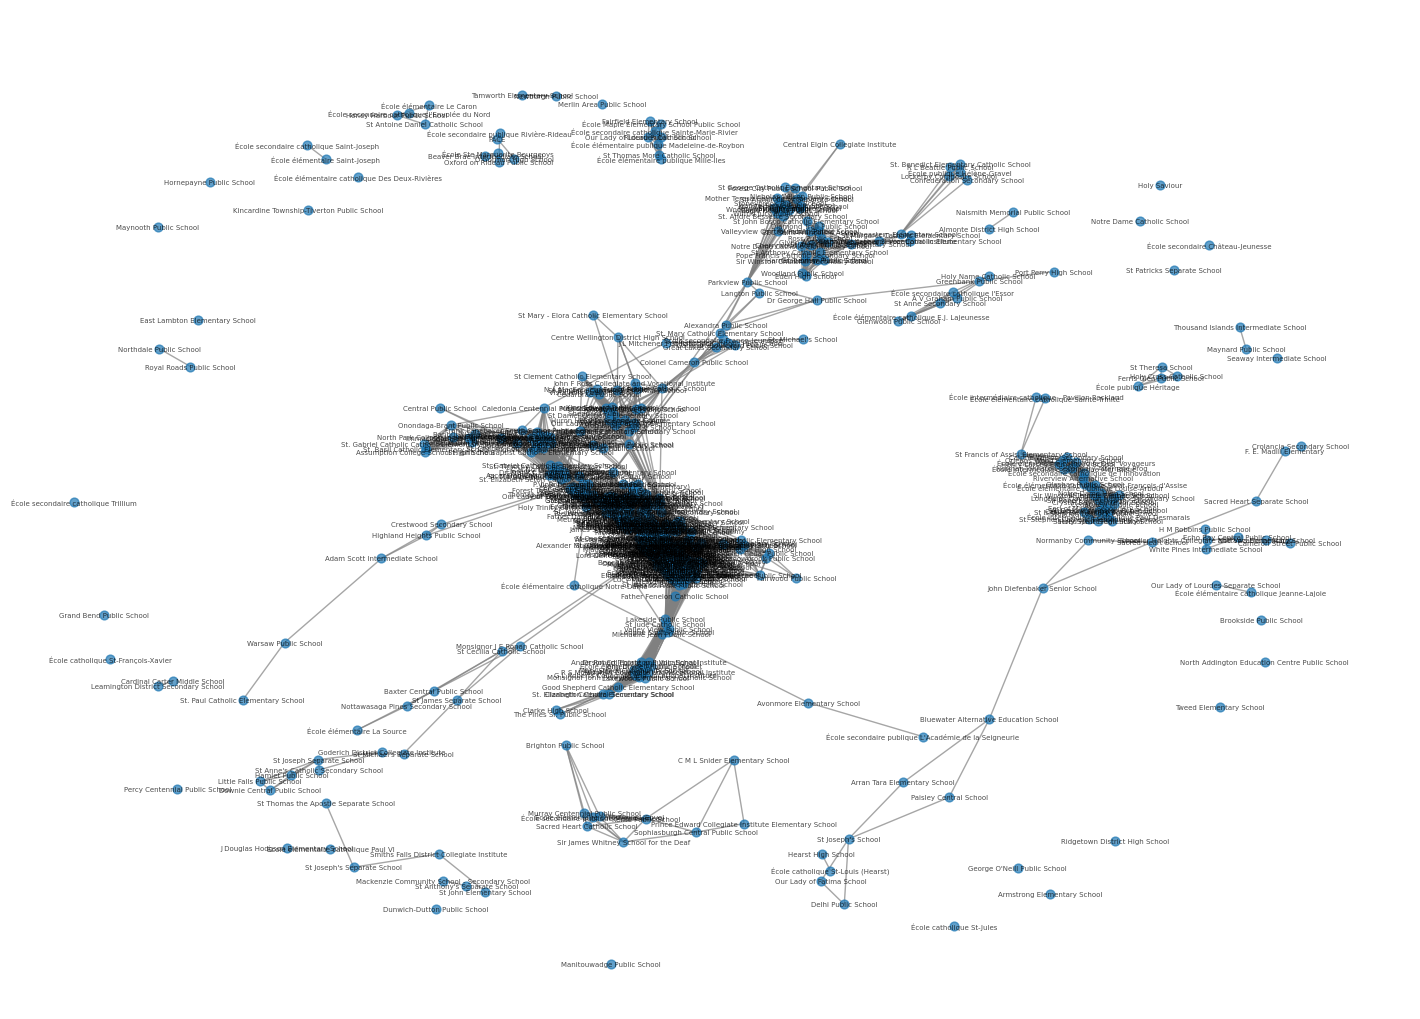

In [28]:
#visualize the school network
plt.figure(figsize=(14, 10))
G=school_net.graph

node_mapping={node: school_net.schools[node].name for node in G.nodes()}

G_relabel=nx.relabel_nodes(G,node_mapping)

nx.draw(G_relabel, with_labels=True, node_size=40, font_size=5, edge_color='gray', alpha=0.7)
plt.show()

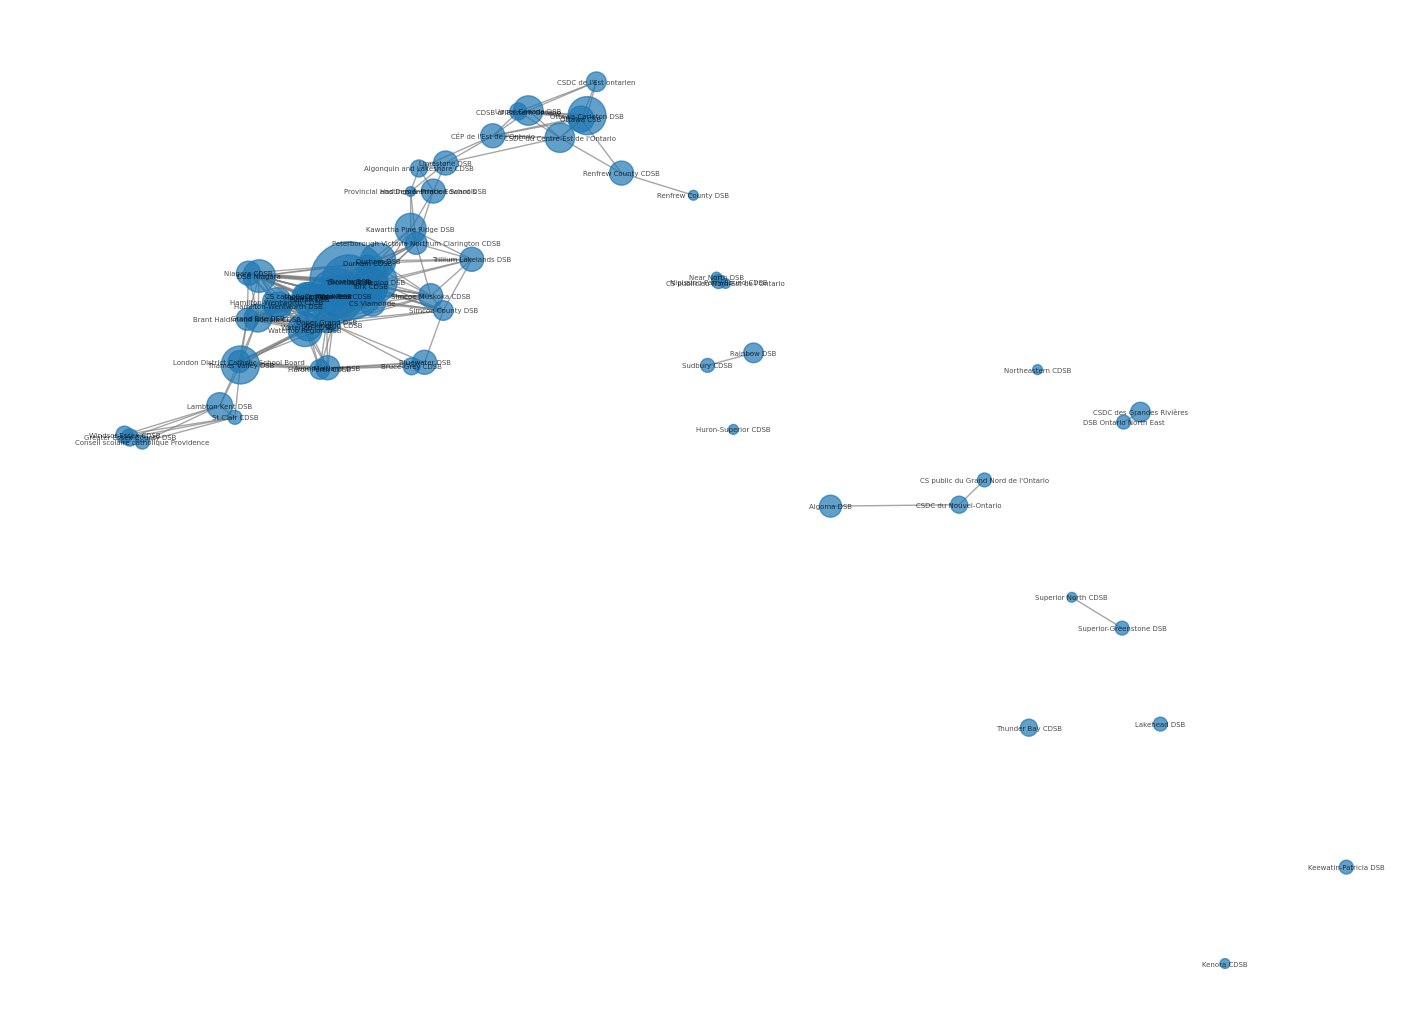

In [29]:
#visualize the school board network
plt.figure(figsize=(14, 10))
G=board_net.graph

pos={board: G.nodes[board]['location'] for board in G.nodes}
sizes = [G.nodes[board]['size']*50 for board in G.nodes()] 



nx.draw(G, pos=pos, with_labels=True, node_size=sizes, font_size=5, edge_color='gray', alpha=0.7)

plt.show()

### Simple Diffusion

In [42]:
import random
from collections import defaultdict

# ---------------------------
# Helpers
# ---------------------------
def create_initial_state_dict(G, default='S'):
    return {n: default for n in G.nodes()}

def count_states(state_dict):
    counts = defaultdict(int)
    for s in state_dict.values():
        counts[s] += 1
    return dict(counts)

def history_to_dataframe(history_counts):
    keys = sorted({k for d in history_counts for k in d.keys()})
    rows = []
    for d in history_counts:
        rows.append({k: d.get(k, 0) for k in keys})
    return pd.DataFrame(rows)
        
def plot_counts(counts_history, title=None, ax=None):
    """Plot time series of counts (list of dicts)."""
    df = history_to_dataframe(counts_history)
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
    df.plot(ax=ax)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Count")
    if title:
        ax.set_title(title)
    ax.grid(True)
    plt.show()
    
def plot_graph_with_states(G, state_dict, node_size=200, pos=None, board_attr=None, figsize=(6,6), ax=None):
    """Simple networkx plotting coloring nodes by state. board_attr optional to annotate shape or border."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # color map from states
    state_to_color = {'S': 'lightgray', 'I': 'tab:blue', 'E': 'tab:orange', 'R': 'tab:green'}
    colors = [state_to_color.get(state_dict.get(n,'S'),'lightgray') for n in G.nodes()]
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.4)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_size, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
    ax.axis('off')

In [31]:
# ---------------------------
# Simple diffusion
# ---------------------------
def simple_diffusion(G, initial_adopters, transmission_prob=0.1, steps=50, seed=None):

    if seed is not None:
        np.random.seed(seed)

    state = create_initial_state_dict(G, default='S')
    for n in initial_adopters:
        if n in state:
            state[n] = 'I'

    node_history = [state.copy()]
    counts_history = [count_states(state)]
    for t in range(steps):
        new_state = state.copy()

        to_infect = set()
        for u in G.nodes():
            if state[u] == 'I':
                for v in G.neighbors(u):
                    if state[v] == 'S':
                        if np.random.rand() < transmission_prob:
                            to_infect.add(v)
        for v in to_infect:
            new_state[v] = 'I'
   
        state = new_state
        node_history.append(state.copy())
        counts_history.append(count_states(state))
        if all(s != 'S' for s in state.values()):
            break
    return node_history, counts_history

#### Threshold Diffusion

In [32]:
#Threshold model - in class practice
def threshold_diffusion(G, initial_adopters,threshold=0.1,steps=50,seed=None):
    if seed is not None:
        random.seed(seed)
    state=create_initial_state_dict(G,default='S')
    for n in initial_adopters:
        if n in state:
            state[n]='I'
    
    node_history=[state.copy()]
    counts_history=[count_states(state)]
    
    for t in range(steps):
        new_state=state.copy()
        for node in G.nodes():
            if state[node]=='S':
                neighbors=list(G.neighbors(node))
                if len(neighbors)==0:
                    continue
                informed_nbr=0
                for n in neighbors:
                    if state[n]=='I':
                        informed_nbr+=1
                frac_informed=informed_nbr/len(neighbors)
                if frac_informed>=threshold:
                    new_state[node]='I'
        state=new_state
        node_history.append(state.copy())
        counts_history.append(count_states(state))
    
    return node_history, counts_history
        
     

In [43]:
#Threshold model revised ver.
        
    # potential improvement:
    # - have the thresholds to be different for each node and be based on node size or other attributes
    # - When selecting neighbors, consider edge weights to add randomization in the information spread process
    
    #more connections -> higher degree -> easier to get informed -> lower threshold
def threshold_diffusion(G, initial_adopters, threshold_distribution=('uniform', 0.1, 0.5),
                    steps=50, seed=None, use_weights=True):             #setting the lowest/highest threshold

    if seed is not None:
        np.random.seed(seed)

    thresholds_used = {}

    low, high = threshold_distribution[1], threshold_distribution[2]
    for n in G.nodes(): #assigning ranodm threshold for each node
        thresholds_used[n] = float(np.random.uniform(low, high))
        
    #considering degree when assigning threshold
    #
    #
        
  
    state = create_initial_state_dict(G, default='S') #S=susceptible
    for n in initial_adopters:
        if n in state:
            state[n] = 'I' #I=infomred/infected
     
    #keeping track of how many nodes are in each state at every step      
    node_history = [state.copy()]
    counts_history = [count_states(state)]

    for t in range(steps):
        print(f"Step {t+1}/{steps}")
        new_state = state.copy()
        for n in G.nodes():
            if state[n] == 'S':
                #calculating the fraction of neighbors that are informed
                neighbors = list(G.neighbors(n))
                
                #if no edge weight defined -> default to 1.0
                if use_weights:
                    total_weight=sum(G[n][nbr].get('weight',1.0) for nbr in neighbors)
                    informed_weight=sum(G[n][nbr].get('weight',1.0) for nbr in neighbors if state[nbr]=='I')
                    frac=informed_weight/total_weight if total_weight>0 else 0
                else:
                    frac = (sum(1 for nbr in neighbors if state[nbr] == 'I') / len(neighbors)) if neighbors else 0
                if frac >= thresholds_used[n]:
                    new_state[n] = 'I'

        state = new_state
        node_history.append(state.copy())
        counts_history.append(count_states(state))
        if node_history[-1] == node_history[-2]:#stop if nothing changes anymore (reaches equilibrium/plateau)
            break
    return node_history, counts_history, thresholds_used


In [34]:
# G = network.graph
G = networkb.graph

# initial = ["466255", "617318", "290130"]
# initial = ["401129", "841498", "255971", "030694"]
initial = ["B66141", "B66192"]

### SIR Model


In [35]:
def sir_diffusion(G, initial_adopters, informed_prob=0.2, recovery_prob=0.3, max_steps=20, seed=None):

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        
    state = create_initial_state_dict(G, default='S')

    # Initialize with adopters
    for n in initial_adopters:
        state[n] = "I"

    node_history = [state.copy()]
    counts_history = [count_states(state)]

    for t in range(max_steps):
        new_states = state.copy()

        for node in G.nodes():
            if state[node] == "S":
                # After exposure, board may adopt with some probability
                if random.random() < informed_prob:
                    new_states[node] = "I"

            elif state[node] == "I":
                # After adoption, board eventually stops influencing
                if random.random() < recovery_prob:
                    new_states[node] = "R"

        state = new_states
        node_history.append(state.copy())
        counts_history.append(count_states(state))

    return node_history, counts_history

#### SEIR Diffusion

In [49]:
def seir_diffusion(G,inital_adopters,timers,recovery_prob=0.2,max_steps=20,seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        
    state=create_initial_state_dict(G, default='S')

    # Initialize with adopters
    for n in initial_adopters:
        state[n]="I"

    node_history=[state.copy()]
    counts_history=[count_states(state)]
    
    for t in range(max_steps):
        new_states=state.copy()
        
        for node in G.nodes():
            if state[node]=="S":
                influence=0
                for nbr in G.neighbors(node):
                    #calulate the influence of neighbors in informed stage
                    if state[nbr]=="I":
                        influence+=G[node][nbr]["weight"]*G.nodes[nbr]["school_size"]
                    
                prob_exposure=min(1.0,influence/(1+influence))
                
                if random.random()<prob_exposure:
                    new_states[node]="E"
            
            elif state[node]=="E":
                timers[node]-=1
                if timers[node]<=0:
                    new_states[node]="I"
                    
            elif state[node]=="I":
                if random.random()<recovery_prob:
                    new_states[node]="R"
        
        state=new_states
        node_history.append(state.copy())
        counts_history.append(count_states(state))
        
    return node_history, counts_history
                
                

### Run simulation

In [ ]:
G = networkb.graph

# Heterogeneous thresholds for each node
thresholds = {}
for n in G.nodes():  
    funding = G.nodes(data=True)[n].get('funding')
    enrolment = G.nodes(data=True)[n].get('enrolment')
    size = G.nodes(data=True)[n].get('school_size')
    
    thresholds[n] = max(0.1, 0.5 - (funding + enrolment + size))
    print(f"Node {n} - Funding: {funding}, Enrolment: {enrolment}, Size: {size}")
    print(f"Threshold: {thresholds[n]:.2f}")

In [48]:
# Randomly select one board from each region as initial adopters
initial = []
for region, group in networkb.region_groups.items():
    selected = random.sample(group, 1)
    initial.extend(selected)
print("Initial adopters:", initial)

Initial adopters: ['B28045', 'B67121', 'B66052', 'B66206', 'B66125']


Simple diffusion steps: 21


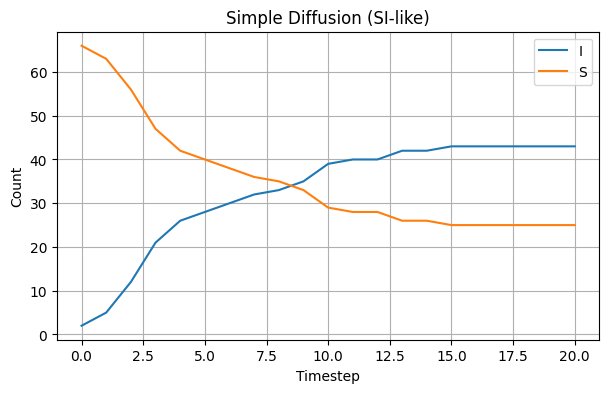

In [36]:
# Simple diffusion
node_hist_si, counts_si = simple_diffusion(G, initial_adopters=initial, transmission_prob=0.1, steps=20, seed=1)
print("Simple diffusion steps:", len(counts_si))
plot_counts(counts_si, title="Simple Diffusion (SI-like)")

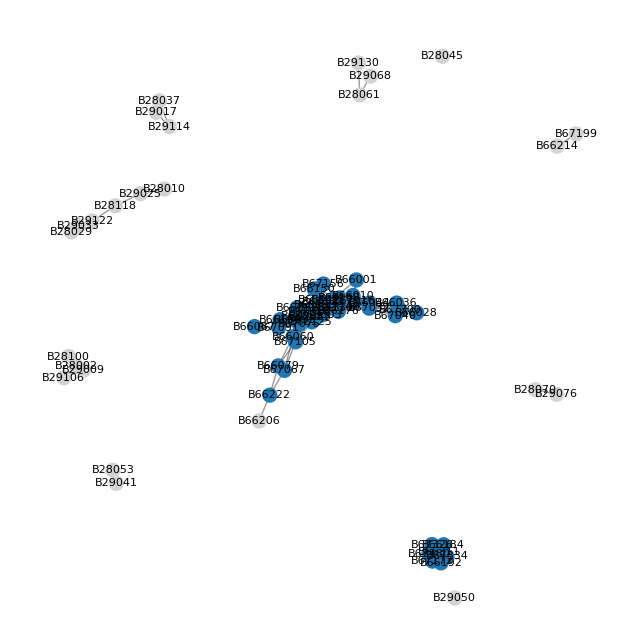

In [37]:
plot_graph_with_states(G, node_hist_si[-1], node_size=100, figsize=(8,8), board_attr='board')

In [38]:
#parsing pdf to dataframe/csv
#https://efis.fma.csc.gov.on.ca/faab/GSN/2025-26%20Education_Funding/Projections/edu-core-education-funding-projections-2025-26-spring-2025-EN.pdf

### Threshold


In [77]:
node_hist_th, counts_th = threshold_diffusion(G, initial_adopters=initial, thresholds_used=thresholds, steps=20, seed=1)
print("Threshold diffusion steps:", len(counts_th))
plot_counts(counts_th, title="Threshold Diffusion")

TypeError: threshold_diffusion() got an unexpected keyword argument 'thresholds_used'

In [ ]:
plot_graph_with_states(G, node_hist_th[-1], figsize=(14, 10))

NameError: name 'node_hist_th' is not defined

#### SEIR

In [53]:
node_hist_seir, counts_seir = seir_diffusion(G, initial_adopters=initial, timers=timers, recovery_prob=0.2, max_steps=20, seed=1)
print("SEIR model steps:", len(counts_seir))
plot_counts(counts_seir, title="SEIR Model")

NameError: name 'timers' is not defined

### Graph Visualization

In [79]:
df = pd.read_csv(data_folder + '/board_summary.csv')

In [54]:
# create folder called visualizations if it does not exist
if not os.path.exists('../visualizations'):
    os.makedirs('../visualizations')
    
visualization_folder = '../visualizations/'

In [57]:
print(df.columns.tolist())

['Board Number', 'Board Name', 'Board Type', 'School Number', 'School Name', 'School Type', 'School Special Condition Code', 'School Level', 'School Language', 'Grade Range', 'Building Suite', 'P.O. Box', 'Street', 'Municipality', 'City', 'Province', 'Postal Code', 'Phone Number', 'Fax Number', 'School Website', 'Board Website', 'Enrolment', 'Latitude', 'Longitude', 'Percentage of Students Whose First Language Is Not English', 'Percentage of Students Whose First Language Is Not French', 'Percentage of Students Who Are New to Canada from a Non-English Speaking Country', 'Percentage of Students Who Are New to Canada from a Non-French Speaking Country', 'Percentage of Students Receiving Special Education Services', 'Percentage of Students Identified as Gifted', 'Percentage of Grade 3 Students Achieving the Provincial Standard in Reading', 'Change in Grade 3 Reading Achievement Over Three Years', 'Percentage of Grade 3 Students Achieving the Provincial Standard in Writing', 'Change in Grad

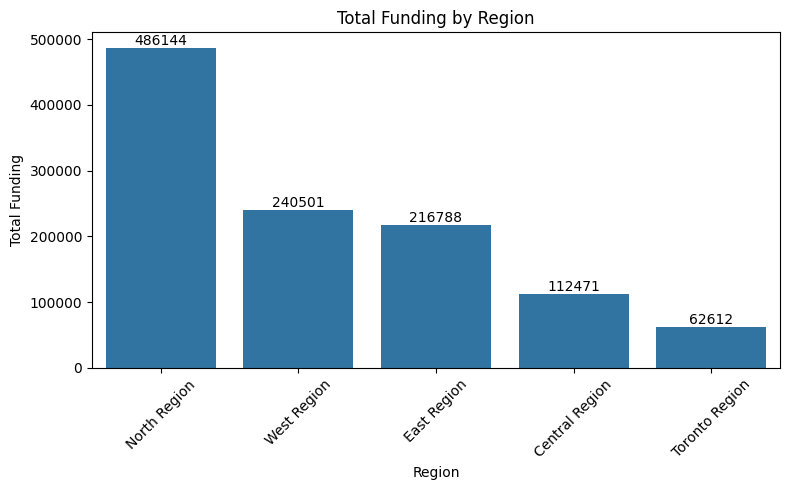

In [72]:
# --- Visualization 1: Total Funding by Region ---
funding_by_region = board_df.groupby('Region')['Funding'].sum().sort_values(ascending=False)

# Create a new figure for the plot with a specific size.
plt.figure(figsize=(8, 5))

ax=sns.barplot(x=funding_by_region.index, y=funding_by_region.values)
for container in ax.containers:
    ax.bar_label(container)

plt.title('Total Funding by Region')
plt.xlabel('Region')
plt.ylabel('Total Funding')

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(visualization_folder + 'total_funding_by_region.png')


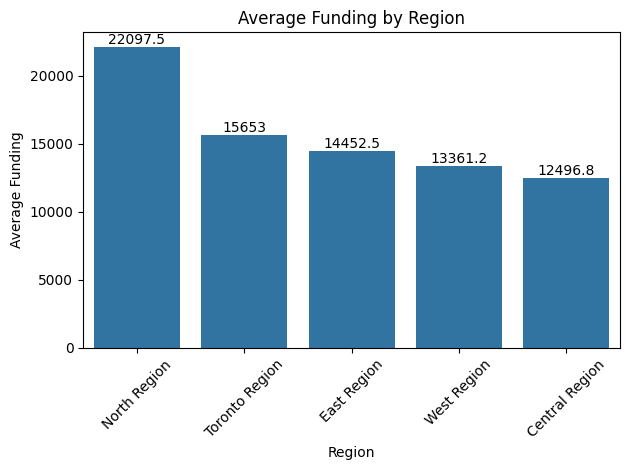

In [75]:
# --- Visualization 2: Average Funding by Region ---
avg_funding_by_region=board_df.groupby('Region')['Funding'].mean().sort_values(ascending=False)

ax=sns.barplot(x=avg_funding_by_region.index, y=avg_funding_by_region.values)
for container in ax.containers:
    ax.bar_label(container)

plt.title('Average Funding by Region')
plt.xlabel('Region')
plt.ylabel('Average Funding')

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(visualization_folder + 'average_funding_by_region.png')

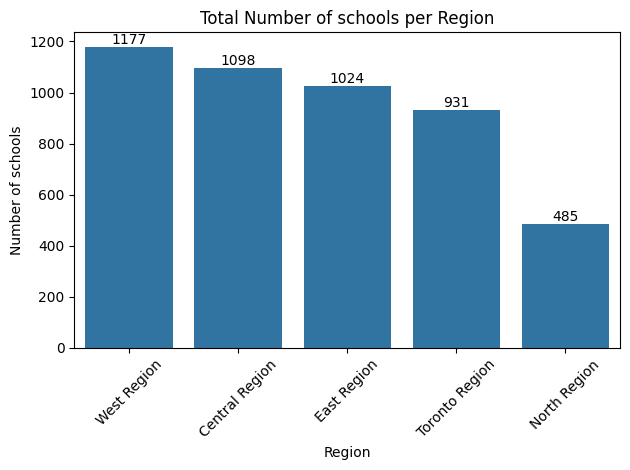

In [76]:
# --- Visualization 3: total number of schools by region ---
schools_by_region=board_df.groupby('Region')['Total'].sum().sort_values(ascending=False)

ax=sns.barplot(x=schools_by_region.index, y=schools_by_region.values)
for container in ax.containers:
    ax.bar_label(container)

plt.title('Total Number of schools per Region')
plt.xlabel('Region')
plt.ylabel('Number of schools')

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(visualization_folder + 'schools_by_region.png')

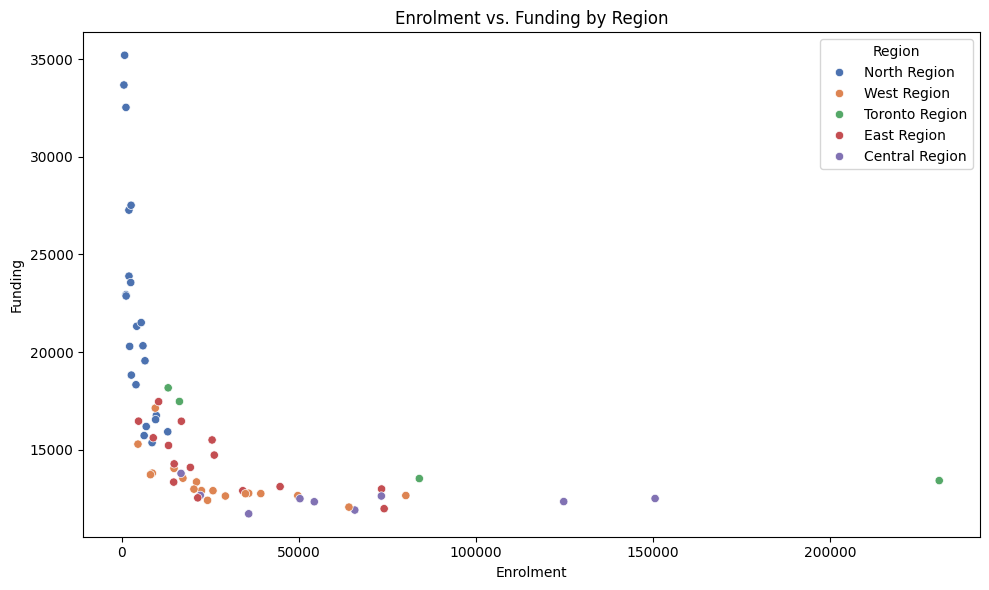

In [80]:
# --- Visualization 4: Enrolment vs. funding ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Enrolment', y='Funding', hue='Region', palette='deep')

plt.title('Enrolment vs. Funding by Region')
plt.xlabel('Enrolment')
plt.ylabel('Funding')
plt.tight_layout()

plt.savefig(visualization_folder + 'enrolment_vs_funding.png')